# Classification of Traffic Accident Severity

## Introduction

Road safety is a primary concern for drivers since traffic accidents can be fatal. Without data, drivers rely on their intuitive perception of the environment to determine the level of cautiousness when they drive, which can be inaccurate at times. For example, drivers may underestimate the danger of speeding on a wet road even after the rain has stopped, or overestimate the risks of driving with light fog. 

Therefore, it is important to educate drivers with correct road safety knowledge that is backed-up by empirical evidence, to boost driving safety and confidence. A multi-class model that classifies accidents of various degrees of severity according to different road conditions can inform drivers of the relevant risks so that they can adjust their level of cautiousness when driving.

## Data I - Description

A multi-class model can be used to classify the various degrees of severity. The features used to classify would be variables such as road condition, light condition, weather, speeding (or not), and the lane the driver is in. For example, consider a driver who is driving under 'wet', 'dark, street lights on', 'not speeding', and on a particular lane. 

A trained model, when assuming that an accident does occur, can classify the severity of the accident. This would provide the driver with the 'worst-case scenario', rather than a probabilistic estimate of an accident occuring. This can still have the effect of inducing an appropriate level of cautiousness in the driver.

The features I will be using for classification are: Speeding, whether accident due to inattention, and whether driver under substance influence. Initially, other features were included, but there were too many categories which resulted in non-convergence of models.

## Data II - Preprocessing

In [157]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import matplotlib as mpl
import matplotlib.pyplot as plt

In [158]:
csv_path = 'C:/Users/Ong Jia Yi/Desktop/STUDY/Co-Cirricular/Coursera - IBM Data Science Professional Certificate/9. Capstone Project/Data-Collisions.csv'
data = pd.read_csv(csv_path)
data = pd.DataFrame(data)

c:\users\ong jia yi\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [159]:
# subset data
selected = ["SEVERITYCODE", "SPEEDING", "INATTENTIONIND", "UNDERINFL", "LIGHTCOND", "ROADCOND", "WEATHER"]
data = data[selected]

In [160]:
# check dimensions
data.shape

(194673, 7)

In [161]:
# checking values of features
features = ["SPEEDING", "INATTENTIONIND", "UNDERINFL", "LIGHTCOND", "ROADCOND", "WEATHER"]
for feature in features:
    print(data[feature].unique())

[nan 'Y']
[nan 'Y']
['N' '0' nan '1' 'Y']
['Daylight' 'Dark - Street Lights On' 'Dark - No Street Lights' nan
 'Unknown' 'Dusk' 'Dawn' 'Dark - Street Lights Off' 'Other'
 'Dark - Unknown Lighting']
['Wet' 'Dry' nan 'Unknown' 'Snow/Slush' 'Ice' 'Other' 'Sand/Mud/Dirt'
 'Standing Water' 'Oil']
['Overcast' 'Raining' 'Clear' nan 'Unknown' 'Other' 'Snowing'
 'Fog/Smog/Smoke' 'Sleet/Hail/Freezing Rain' 'Blowing Sand/Dirt'
 'Severe Crosswind' 'Partly Cloudy']


In [162]:
# replace 'nan' with 'N' for binary cases
data["SPEEDING"] = data["SPEEDING"].fillna("N")
data["INATTENTIONIND"] = data["INATTENTIONIND"].fillna("N")

# unify labelling for UNDERINFL
data["UNDERINFL"].replace('0', 'N', inplace=True)
data["UNDERINFL"].replace('1', 'Y', inplace=True)

# drop 'nan' values
data.dropna(axis=0, inplace=True)

In [163]:
data.shape

(189337, 7)

In [164]:
# convert binary categorical features to numerical values
data["SPEEDING"].replace(to_replace=['N', 'Y'], value=[0,1], inplace=True)
data["INATTENTIONIND"].replace(to_replace=['N', 'Y'], value=[0,1], inplace=True)
data["UNDERINFL"].replace(to_replace=['N', 'Y'], value=[0,1], inplace=True)

In [165]:
# checking number of positives
a = data["SPEEDING"].value_counts().to_frame()
b = data["INATTENTIONIND"].value_counts().to_frame()
c = data["UNDERINFL"].value_counts().to_frame()
pd.concat([a,b,c], axis=1)

,SPEEDING,INATTENTIONIND,UNDERINFL
0,180018,159614,180239
1,9319,29723,9098


In [166]:
# Use one hot encoding technique to conver categorical varables to binary variables
# "LIGHTCOND", "ROADCOND", "WEATHER"
Feature = data[features]
Feature = pd.concat([Feature, pd.get_dummies(data['LIGHTCOND']),
                              pd.get_dummies(data['ROADCOND']),
                              pd.get_dummies(data['WEATHER'])], axis=1)
Feature.drop(["LIGHTCOND", "ROADCOND", "WEATHER"], axis = 1, inplace=True)

In [167]:
# checking number of positives
table = []
for col in range(3, Feature.shape[1]):
    counts = Feature.iloc[:,col].value_counts()
    table.append(counts)
pd.concat(table, axis=1)

,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dark - Unknown Lighting,Dawn,Daylight,Dusk,Other,Unknown,Dry,...,Clear,Fog/Smog/Smoke,Other,Overcast,Partly Cloudy,Raining,Severe Crosswind,Sleet/Hail/Freezing Rain,Snowing,Unknown
0,187802,188145,140897,189326,186835,73260,183448,189102,175881,65037,...,78329,188768,188513,161656,189332,156220,189312,189224,188436,174298
1,1535,1192,48440,11,2502,116077,5889,235,13456,124300,...,111008,569,824,27681,5,33117,25,113,901,15039


In [168]:
# define datasets
X = Feature
y = data['SEVERITYCODE'].values.astype(str)

## Data III - Visualization

In the following three tables, we can see that the proportion of level 2 severity is higher when any of the three cases is true (speeding, inattentive, or influenced by substance). This means that these features do indeed have an effect on the severity of accidents when it happens.

In [169]:
data.groupby(['WEATHER'])['SEVERITYCODE'].value_counts(normalize=True)

WEATHER                   SEVERITYCODE
Blowing Sand/Dirt         1               0.727273
                          2               0.272727
Clear                     1               0.677429
                          2               0.322571
Fog/Smog/Smoke            1               0.671353
                          2               0.328647
Other                     1               0.859223
                          2               0.140777
Overcast                  1               0.684296
                          2               0.315704
Partly Cloudy             2               0.600000
                          1               0.400000
Raining                   1               0.662771
                          2               0.337229
Severe Crosswind          1               0.720000
                          2               0.280000
Sleet/Hail/Freezing Rain  1               0.752212
                          2               0.247788
Snowing                   1               0

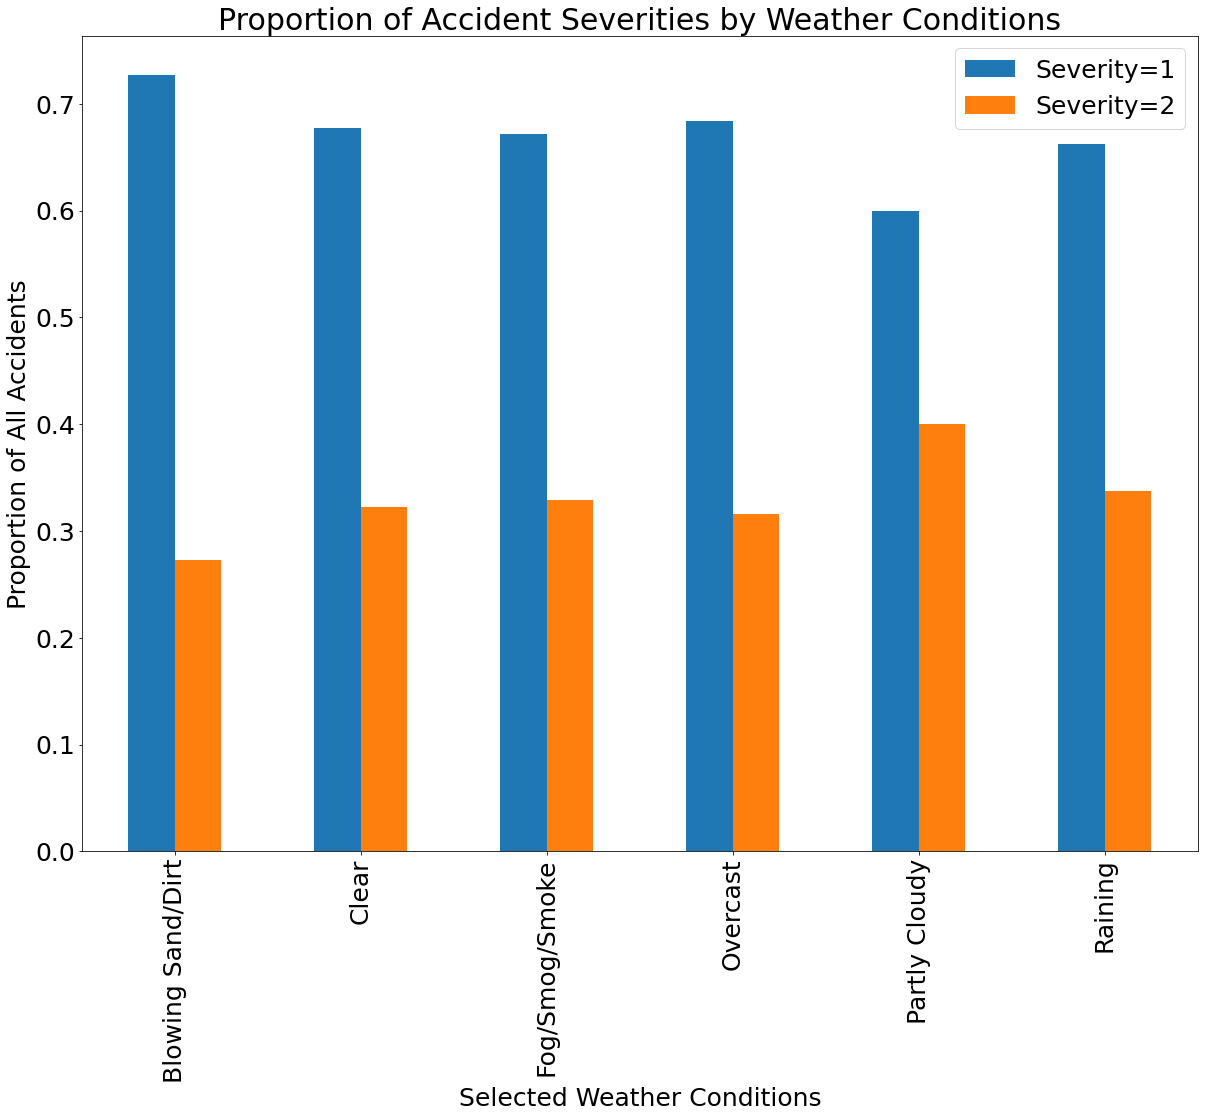

In [170]:
# plot bar chart for proportion comparison
plot_data = {
    "Severity=1": [0.727273, 0.677429, 0.671353, 0.684296, 0.600000, 0.662771],
    "Severity=2": [0.272727, 0.322571, 0.328647, 0.315704, 0.400000, 0.337229]
}
plot_data = pd.DataFrame(plot_data)
plot_data.index = ["Blowing Sand/Dirt", "Clear", "Fog/Smog/Smoke", "Overcast", "Partly Cloudy", "Raining"]

plot_data.plot(kind = "bar", figsize=(20,15))
plt.title("Proportion of Accident Severities by Weather Conditions",
         fontsize=30)
plt.xlabel("Selected Weather Conditions")
plt.ylabel("Proportion of All Accidents")
plt.rc('axes', labelsize=25)
plt.rc('legend', fontsize=25)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)

In [171]:
underinfl = data.groupby(['UNDERINFL'])['SEVERITYCODE'].value_counts(normalize=True)
underinfl

UNDERINFL  SEVERITYCODE
0          1               0.703172
           2               0.296828
1          1               0.609585
           2               0.390415
Name: SEVERITYCODE, dtype: float64

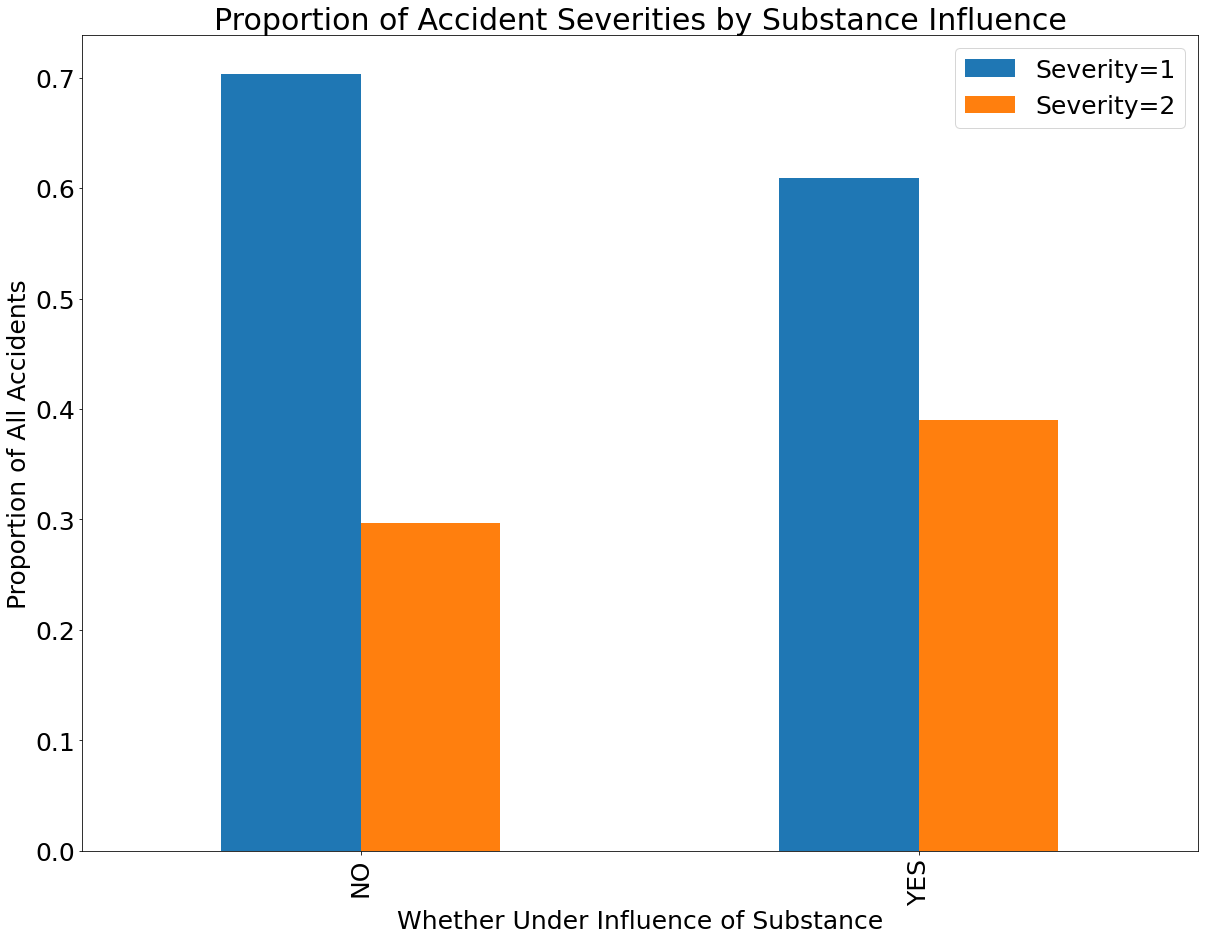

In [172]:
# plot bar chart for proportion comparison
plot_data = {
    "Severity=1": [0.703172, 0.609585],
    "Severity=2": [0.296828, 0.390415]
}
plot_data = pd.DataFrame(plot_data)
plot_data.index = ["NO", "YES"]

plot_data.plot(kind = "bar", figsize=(20,15))
plt.title("Proportion of Accident Severities by Substance Influence",
         fontsize=30)
plt.xlabel("Whether Under Influence of Substance")
plt.ylabel("Proportion of All Accidents")
plt.rc('axes', labelsize=25)
plt.rc('legend', fontsize=25)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)

## Methodology

I take a metric-based approach in selecting the best classification algorithm to generate insights.

In [173]:
# normalize data
#X = preprocessing.StandardScaler().fit(X).transform(X)

# split "train_loan.csv" data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# verifying set dimensions
print("Training set: ", X_train.shape, y_train.shape)
print("Testing set: ", X_test.shape, y_test.shape)

Training set:  (151469, 32) (151469,)
Testing set:  (37868, 32) (37868,)


## Methodology - Decision Tree

Select the 'best' Decision Tree model by iteratively testing the max_depth parameter.

In [174]:
limit = 10

# initialize scores
acc_scores = np.zeros((limit))
f1_scores = np.zeros((limit))

i = 0
for maxdepth in range(1, limit+1):
    # for each maxdepth, run model
    Tree_model = DecisionTreeClassifier(criterion="entropy", max_depth = maxdepth)
    Tree_model.fit(X_train, y_train)
    predicted = Tree_model.predict(X_test)
    # for each maxdepth store scores
    acc_scores[i] = accuracy_score(y_test, predicted)
    f1_scores[i] = f1_score(y_test, predicted, average='weighted')
    i = i + 1

In [175]:
table = pd.concat([pd.DataFrame([i for i in range(1, 11)]),
                   pd.DataFrame(acc_scores), 
                   pd.DataFrame(f1_scores)], axis=1)
table.columns = ["MaxDepth", "AccScore", "F1Score"]
table.sort_values(["AccScore"], ascending=False, axis=0)

,MaxDepth,AccScore,F1Score
5,6,0.700380,0.578062
7,8,0.700275,0.578107
6,7,0.700248,0.578095
8,9,0.700248,0.578191
4,5,0.700195,0.576851
0,1,0.700169,0.576692
1,2,0.700169,0.576692
2,3,0.700169,0.576692
3,4,0.700143,0.576679
9,10,0.699958,0.578242


In [176]:
# seeing that max_depth = 5 has the highest accuracy score
# and that the F1 scores are not very different
# choose the best Decision Tree model with max_depth = 5

Tree_model = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
Tree_model.fit(X_train, y_train)
predicted = Tree_model.predict(X_test)

In [177]:
Tree_f1 = f1_score(y_test, predicted, average='weighted')
Tree_acc = accuracy_score(y_test, predicted)

## Methodology - Logistic Regression

Select the 'best' Decision Tree model by iteratively testing the solver parameter.

In [178]:
solvers = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]

# initialize scores
acc_scores = np.zeros(5)
f1_scores = np.zeros(5)
log_losses = np.zeros(5)

i = 0
for solver in solvers:
    # for each solver, run model
    LR_model = LogisticRegression(C=0.01, solver=solver).fit(X_train, y_train)
    predicted = LR_model.predict(X_test)
    predicted_prob = LR_model.predict_proba(X_test)
    # for each solver store scores
    acc_scores[i] = accuracy_score(y_test, predicted)
    f1_scores[i] = f1_score(y_test, predicted, average='weighted')
    log_losses[i] = log_loss(y_test,  predicted_prob)
    i = i + 1

In [179]:
table = pd.concat([pd.DataFrame(solvers),
                   pd.DataFrame(acc_scores), 
                   pd.DataFrame(f1_scores),
                   pd.DataFrame(log_losses)], axis=1)
table.columns = ["Solver", "AccScore", "F1Score", "LogLoss"]
table.sort_values(["LogLoss"], axis=0)

,Solver,AccScore,F1Score,LogLoss
0,newton-cg,0.700169,0.576741,0.587845
3,sag,0.700169,0.576741,0.587846
4,saga,0.700169,0.576741,0.587846
1,lbfgs,0.700169,0.576741,0.587846
2,liblinear,0.700169,0.576741,0.587892


In [180]:
# seeing that the scores are not very different
# choose the best Logistic Regression model with default Solver = "lbfgs"

LR_model = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train, y_train)
predicted = LR_model.predict(X_test)
LR_f1 = f1_score(y_test, predicted, average='weighted')
LR_acc = accuracy_score(y_test, predicted)

In [181]:
table = {
    "Algorithm": ["Decision Tree", "LogisticRegression"],
    "F1-score": [Tree_f1, LR_f1],
    "Accuracy": [Tree_acc, LR_acc]
}

table = pd.DataFrame(table)
table

,Algorithm,F1-score,Accuracy
0,Decision Tree,0.576851,0.700195
1,LogisticRegression,0.576741,0.700169


Since the scores are not significantly different, I will use the Logistic Regression model since it can predict probabilities.

## Results

Demonstrate how the Logistic Model can provide real-time information to drivers.

In [107]:
data["LIGHTCOND"].unique()

array(['Daylight', 'Dark - Street Lights On', 'Dark - No Street Lights',
       'Unknown', 'Dusk', 'Dawn', 'Dark - Street Lights Off', 'Other',
       'Dark - Unknown Lighting'], dtype=object)

In [108]:
data["ROADCOND"].unique()

array(['Wet', 'Dry', 'Unknown', 'Snow/Slush', 'Ice', 'Other',
       'Sand/Mud/Dirt', 'Standing Water', 'Oil'], dtype=object)

In [109]:
data["WEATHER"].unique()

array(['Overcast', 'Raining', 'Clear', 'Unknown', 'Other', 'Snowing',
       'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt',
       'Severe Crosswind', 'Partly Cloudy'], dtype=object)

In [182]:
# define new inputs with default value as 0
input = pd.concat([pd.DataFrame(Feature.columns.values), 
                   pd.DataFrame(np.zeros(32))], axis=1)
input.columns = ["Condition", "Input Value"]
input.head()

,Condition,Input Value
0,SPEEDING,0.0
1,INATTENTIONIND,0.0
2,UNDERINFL,0.0
3,Dark - No Street Lights,0.0
4,Dark - Street Lights Off,0.0


In [194]:
# change input conditions from default
new_input = input
# set human condition
new_input.loc[(input.Condition == 'UNDERINFL'), "Input Value"] = 1
# set lighting condition
new_input.loc[(input.Condition == 'Dark - No Street Lights'), "Input Value"] = 1
# set road condition
new_input.loc[(input.Condition == 'Wet'), "Input Value"] = 1
# set weather condition
new_input.loc[(input.Condition == 'Raining'), "Input Value"] = 1
new_input.head()

,Condition,Input Value
0,SPEEDING,0.0
1,INATTENTIONIND,0.0
2,UNDERINFL,1.0
3,Dark - No Street Lights,1.0
4,Dark - Street Lights Off,0.0


In [195]:
# reshaping one-sample to 2D input for prediction
newinput = new_input["Input Value"].values
newinput = newinput.reshape(1, -1)
LR_model.predict(newinput)

array(['2'], dtype='<U21')

The model predicts a severity level of 2 given the input conditions. Try same environmental conditions but without influence of drugs.

In [196]:
# change input conditions from default
new_input = input
# set human condition
new_input.loc[(input.Condition == 'UNDERINFL'), "Input Value"] = 0
# set lighting condition
new_input.loc[(input.Condition == 'Dark - No Street Lights'), "Input Value"] = 1
# set road condition
new_input.loc[(input.Condition == 'Wet'), "Input Value"] = 1
# set weather condition
new_input.loc[(input.Condition == 'Raining'), "Input Value"] = 1
new_input.head()

# reshaping one-sample to 2D input for prediction
newinput = new_input["Input Value"].values
newinput = newinput.reshape(1, -1)
LR_model.predict(newinput)

array(['1'], dtype='<U21')

The models provide empirical evidence against driving behaviours such as substance-use driving.